In [1]:
#basic libraries
import h2o
import numpy as np
import pandas as pd
import re
import joblib

#scikit-learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

#h2o models and grid search
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#XGBoost
from xgboost import XGBClassifier

#model explanation
import shap

%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Model Training
After finishing the data preprocessing and imputation, I will train the model. I will use 3 algorithms to compare the result, and use the top 2 as baseline models. The algorithms are gradient boosting, deep learning, and XGBoost. For the first 2 algorithms, I will use the H2O library. For the XGBoost algorithm, I will use the XGBoost library since it is not supported in the current version of H2O (I'm using windows). In the next notebook, I will perform feature engineering to add features to the dataset, hopefully making the model better. If the model is not better, I will use the best of the baseline models to create a prediction pipeline.

In [2]:
#reading the final dataset
df_use = pd.read_csv('data/final_data.csv')

In [3]:
#initializing H2O. Reminder: H2O needs java.
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Users\agust\Anaconda3\envs\h2o_loan_classification\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\agust\AppData\Local\Temp\tmptlxtsyl4
  JVM stdout: C:\Users\agust\AppData\Local\Temp\tmptlxtsyl4\h2o_agust_started_from_python.out
  JVM stderr: C:\Users\agust\AppData\Local\Temp\tmptlxtsyl4\h2o_agust_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Jakarta
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,1 month and 19 days
H2O_cluster_name:,H2O_from_python_agust_8lkuv4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.854 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [4]:
#parsing the dataframe to H2O dataframe
hf = h2o.H2OFrame(df_use)

#separating predictors and response
predictors = list(df_use.columns[1:])
response = "loan_status"

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
#create train, test, and validation dataset
train_temp, test = hf.split_frame(ratios = [.8], seed = 42)
train, val = train_temp.split_frame(ratios = [.8], seed = 42)

## Using Gradient Boosting Model
For this part, I will use H2OGridSearch combined with H2OGradientBoostingEstimator to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most.

In [6]:
def train_gbm_h2o(predictors, response, train, test, val, learn_rate, max_depth, ntrees, sample_rate, col_sample_rate):
    #hyperparameters to tune
    gbm_params1 = {'learn_rate': learn_rate,
                'max_depth': max_depth,
                'ntrees': ntrees,
                'sample_rate': sample_rate,
                'col_sample_rate': col_sample_rate}

    #initializing grid search
    gbm_grid1 = H2OGridSearch(
        model=H2OGradientBoostingEstimator,
        grid_id='gbm_grid1',
        hyper_params=gbm_params1
    )
    
    #train the model
    gbm_grid1.train(
        x=predictors,
        y=response,
        training_frame=train,
        validation_frame=val,  # Include your validation frame here
        seed=42
    )
    
    gbm_gridperf1 = gbm_grid1.get_grid(sort_by='aucpr', decreasing=True)
    
    #get the best model
    best_gbm1 = gbm_gridperf1.models[0]

    #evaluate the model against the test data
    gbm_perf = best_gbm1.model_performance(test)
    
    return best_gbm1, gbm_perf, gbm_gridperf1

In [7]:
learn_rate = [0.01, 0.05, 0.1]
max_depth = [5, 7, 9]
ntrees = [300, 500, 700]
sample_rate = [0.5, 0.8, 1.0]
col_sample_rate = [0.25, 0.5, 1.0]
best_gbm1, gbm_perf, gbm_gridperf1 = train_gbm_h2o(predictors, response, train, test, val, learn_rate, max_depth, ntrees, sample_rate, col_sample_rate)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


In [8]:
gbm_gridperf1

,col_sample_rate,learn_rate,max_depth,ntrees,sample_rate,model_ids,aucpr
,0.5,0.01,9.0,700.0,0.8,gbm_grid1_model_155,0.4907092
,0.5,0.01,7.0,700.0,1.0,gbm_grid1_model_227,0.4903254
,1.0,0.01,9.0,700.0,0.8,gbm_grid1_model_156,0.4895698
,0.25,0.01,9.0,700.0,0.8,gbm_grid1_model_154,0.4895594
,1.0,0.01,7.0,700.0,0.8,gbm_grid1_model_147,0.4895342
,1.0,0.05,5.0,300.0,1.0,gbm_grid1_model_168,0.4894263
,0.5,0.01,7.0,700.0,0.8,gbm_grid1_model_146,0.4894002
,0.25,0.01,9.0,700.0,1.0,gbm_grid1_model_235,0.4892497
,0.5,0.01,9.0,500.0,0.8,gbm_grid1_model_128,0.4892406
,1.0,0.05,5.0,300.0,0.5,gbm_grid1_model_6,0.4891944


In [9]:
print(gbm_perf)

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.18219427094123514
RMSE: 0.4268422084813487
LogLoss: 0.5436201619563155
Mean Per-Class Error: 0.36949721360055027
AUC: 0.6918287015983052
AUCPR: 0.4791954127471261
Gini: 0.38365740319661046

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24921493469792444
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    6919          5860            0.4586   (5860.0/12779.0)
loan_refused  1410          3618            0.2804   (1410.0/5028.0)
Total         8329          9478            0.4083   (7270.0/17807.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.249215     0.498828  252
max f2                       0.13162      0.678303  344
max f0point5                 0.386468     0.46

The AUC score for this model is 0.6918, which is not bad. Based on the confusion matrix, I can see that the model does a pretty good job in predicting a refused loan when the loan is supposed to be refused. However, the performance is not too god for predicting loans which are given. The number of false positives are almost the same as the number of true positives.

I will need to calculate additional metrics to determine the performance of the model. The additional metrics I will calculate are F1 score, precision, and recall. All of them are weighted, given that the model has class imbalances. This will be done in the model summary section. 

Before calculating the metrics, I will generate the shap summary plot to see what features are the most important in affecting the result of the model's prediction.

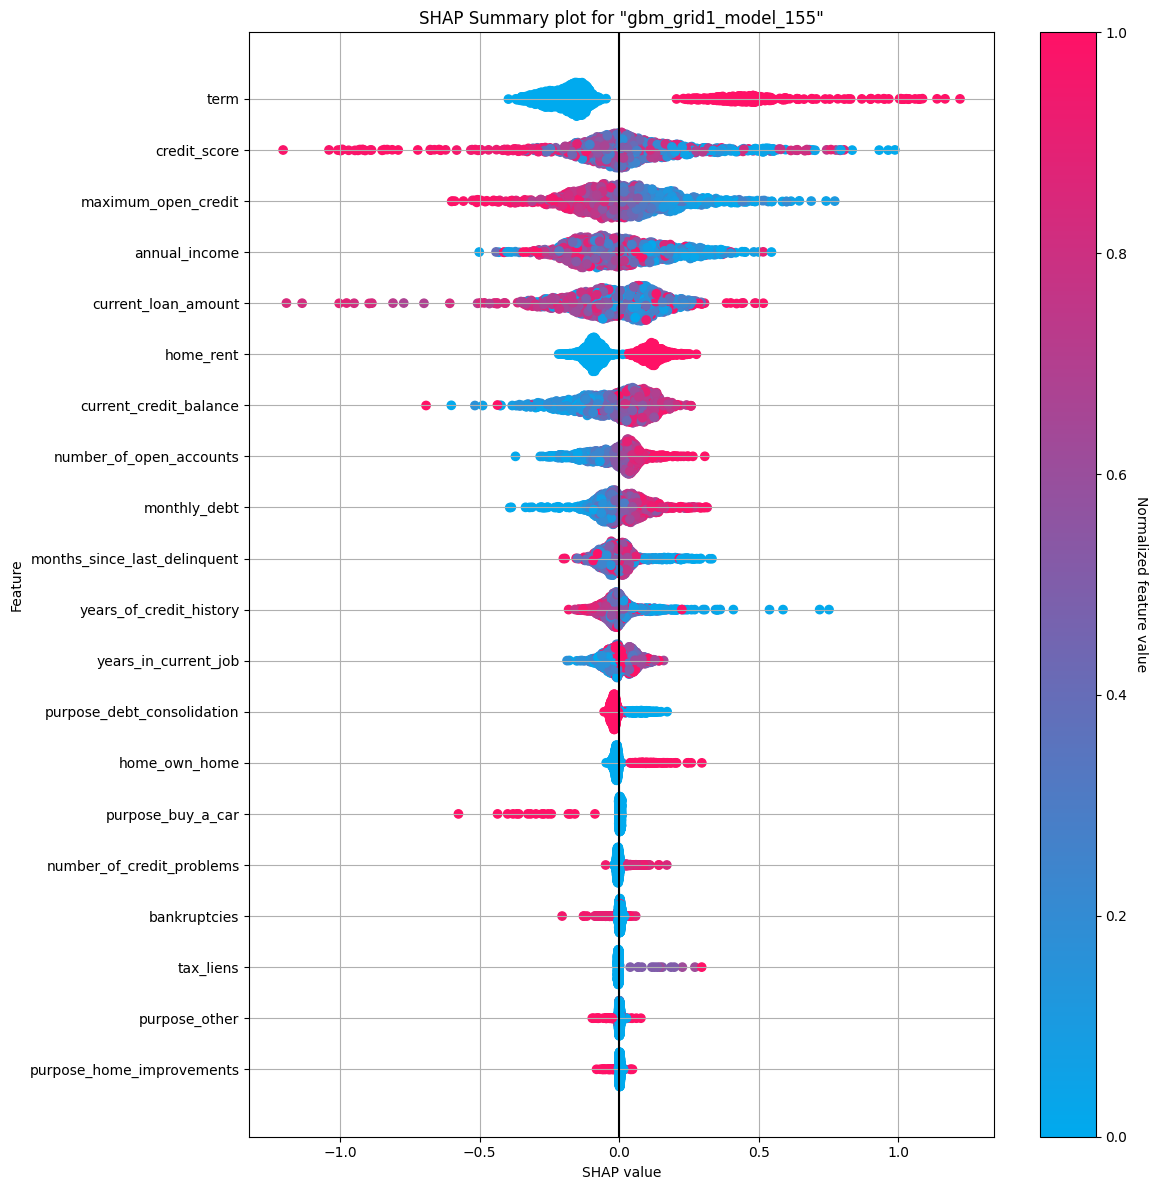

In [10]:
best_gbm1.shap_summary_plot(test)

The takeaway from shap summary plot are as follows:
1. The top 3 features that affect the prediction result of the model is term, credit score, and maximum open credit. These are the top 3 most important features.
2. Starting from purpose_debt_consolidation to purpose_other, these features don't affect the prediction result of the model.
3. The beeswarm is a bit different. As far as I know, the right part of the plot (after the 0.0 value on the X axis) is for class 1, which is loan_given, and vice versa. But this summary plot shows that when the loan term is long (red dots), the model predicts that the loan is given. However, based on the barchart, I think that the shorter term loans tend to be given. [See this image for reference](/images/term_loanstatus_barchart.png). I have to check this further.

Nevertheless, I will continue to create a bar chart for the most important features.

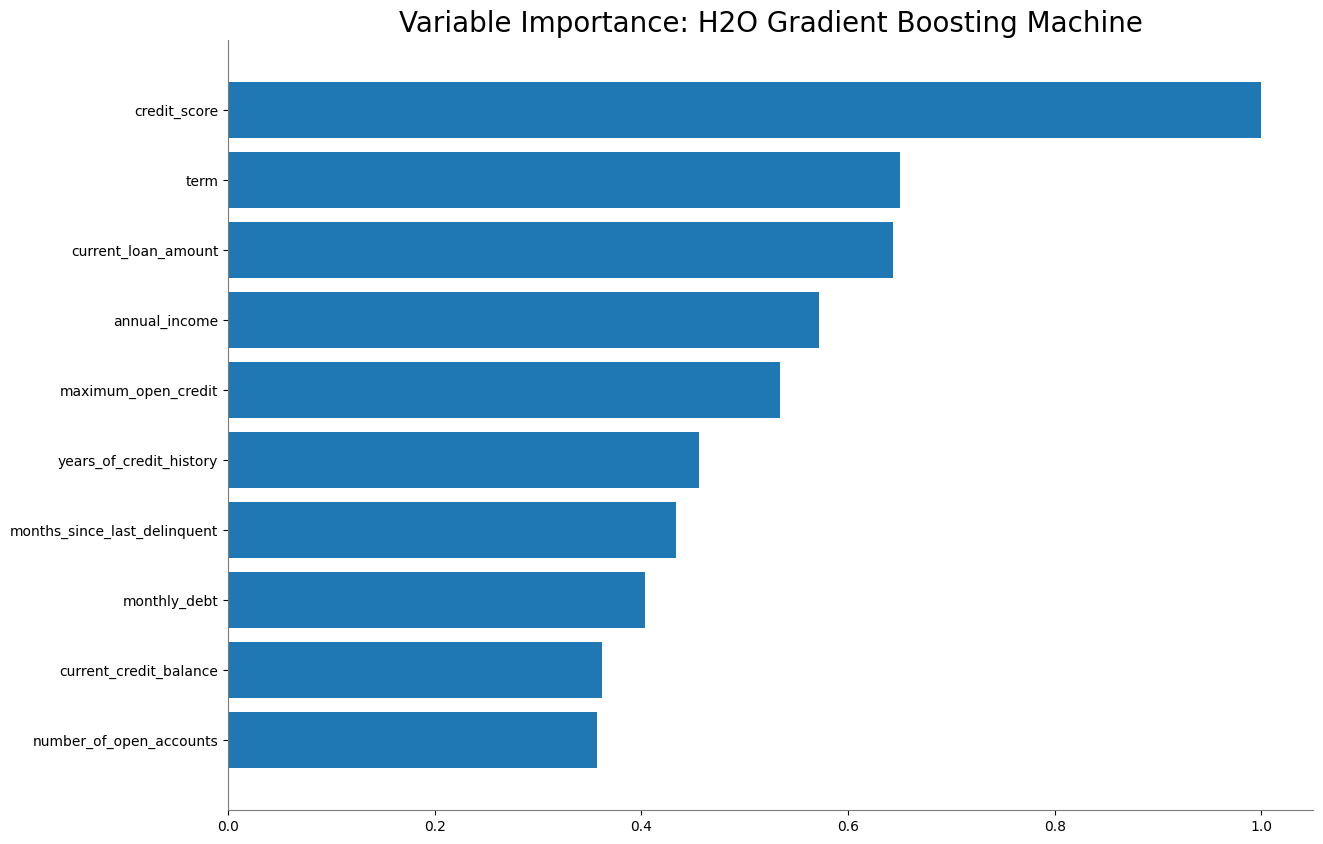

<Figure size 640x480 with 0 Axes>

In [11]:
best_gbm1.varimp_plot()

Based on the more traditional method, which is how often a feature is used to split the trees in this case, the most important features are credit score, term, and current loan amount.

### Model Summary

In [12]:
def calculate_metrics_summary(h2o_perf, df, model_name):
    #calculate precision, recall, and support for class 0 and 1
    precision_class_0 = h2o_perf.precision()[0][0]
    precision_class_1 = h2o_perf.precision()[0][1]
    recall_class_0 = h2o_perf.recall()[0][0]
    recall_class_1 = h2o_perf.recall()[0][1]
    support_class_0 = df.loan_status.value_counts()['loan_refused']
    support_class_1 = df.loan_status.value_counts()['loan_given']
    
    #calculate weighted precision and recall
    precision = (precision_class_0 * support_class_0 + precision_class_1 * support_class_1) / (support_class_0 + support_class_1)
    recall = (recall_class_0 * support_class_0 + recall_class_1 * support_class_1) / (support_class_0 + support_class_1)
    
    #calculate F1 score for class 0 and class 1
    f1_class_0 = 2 * (precision_class_0 * recall_class_0) / (precision_class_0 + recall_class_0)
    f1_class_1 = 2 * (precision_class_1 * recall_class_1) / (precision_class_1 + recall_class_1)
    
    f1 = (f1_class_0 * support_class_0 + f1_class_1 * support_class_1) / (support_class_0 + support_class_1)
    auc = h2o_perf.auc()
    
    print(f"The F1 score for {model_name} is {f1}")
    print(f"The precision score for {model_name} is {precision}")
    print(f"The recall score for {model_name} is {recall}")
    print(f"The AUC score for {model_name} is {auc}")
    
    return f1, precision, recall, auc

In [13]:
f1_gbm, precision_gbm, recall_gbm, auc_gbm = calculate_metrics_summary(gbm_perf, df_use, 'GBM')

The F1 score for GBM is 0.7368699813152678
The precision score for GBM is 0.9829205973919817
The recall score for GBM is 0.7272684420894501
The AUC score for GBM is 0.6918287015983052


The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a good balance between making correct positive predictions and capturing positive instances.
2. Based on the precision score, this model is able to predict 98.29% approved loans when the loans are supposed to be approved. This is a good score for the model.
3. Based on the recall score, this model can recognize 72.72% of all eligible loan applicants. Although this number is considerably good, this means that the business has the chance of losing 27.28% eligible loan applicants.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) is somewhat good.

In [14]:
#saving model
model_path = h2o.save_model(
  best_gbm1,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\gbm_grid1_model_155'

# Using Deep Learning
For this part, I will use H2OGridSearch combined with H2ODeepLearningEstimator to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most.

In [15]:
def train_dl_h2o(predictors, response, train, test, val, hidden, epochs, balance_classes, activation):
    #hyperparameters to tune
    hyper_params = {
        'hidden': hidden,
        'epochs': epochs,
        'balance_classes': balance_classes,
        'activation': activation
    }

    #initialize grid search
    dl_grid = H2OGridSearch(
        model=H2ODeepLearningEstimator,
        grid_id='dl_grid',
        hyper_params=hyper_params
    )
    #train the model
    dl_grid.train(
        x=predictors,
        y=response,
        training_frame=train,
        validation_frame=val
    )
    
    # Get the best model from the grid search
    best_dl_model = dl_grid.get_grid()[0]

    #evaluate model performance against the test data
    dl_perf = best_dl_model.model_performance(test)
    
    return best_dl_model, dl_perf

In [16]:
hidden = [[16, 16], [16, 32, 64], [16, 32, 64, 128]]
epochs = [50, 100, 200]
balance_classes = [True, False]
activation = ['Rectifier', 'Tanh', 'RectifierWithDropout','Maxout']
best_dl_model, dl_perf = train_dl_h2o(predictors, response, train, test, val, hidden, epochs, balance_classes, activation)

deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


In [17]:
print(dl_perf)

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.18485588386780527
RMSE: 0.42994869911165595
LogLoss: 0.551741004739872
Mean Per-Class Error: 0.374275222382485
AUC: 0.6780014935377457
AUCPR: 0.46524590064364296
Gini: 0.3560029870754915

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27419587432435266
              loan_given    loan_refused    Error    Rate
------------  ------------  --------------  -------  ----------------
loan_given    7018          5761            0.4508   (5761.0/12779.0)
loan_refused  1497          3531            0.2977   (1497.0/5028.0)
Total         8515          9292            0.4076   (7258.0/17807.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274196     0.493156  244
max f2                       0.129613     0.67091   349
max f0point5                 0.385729  

The AUC score of the deep learning model is lower compared to the gradient boosting model. So, I will not save this model first. I will plot the feature importance. Since shap is not supported here, I will go straight to plot the bar chart of the feature importance.

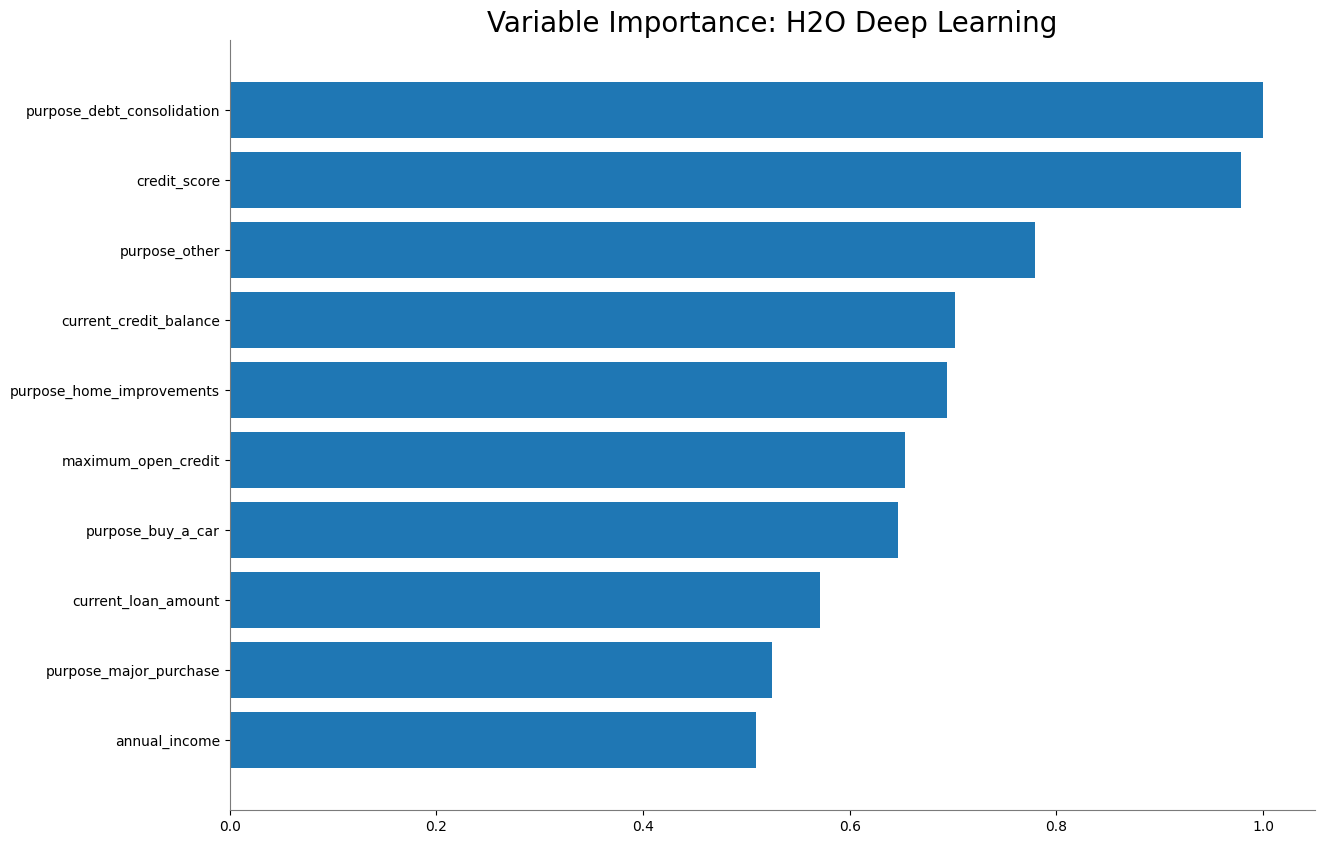

<Figure size 640x480 with 0 Axes>

In [18]:
best_dl_model.varimp_plot()

The result of this feature importance plot is a bit different compared to the gradient boosting one. The most important feature is purpose_debt_consolidation, followed by credit_score and annual_income.

### Model Summary
I will create a summary for the deep learning model with the same specifications as the gradient boosting model.

In [19]:
f1_dl, precision_dl, recall_dl, auc_dl = calculate_metrics_summary(dl_perf, df_use, 'Deep Learning')

The F1 score for Deep Learning is 0.7391973973166253
The precision score for Deep Learning is 0.9984542183393693
The recall score for Deep Learning is 0.7285024344132163
The AUC score for Deep Learning is 0.6780014935377457


The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a good balance between making correct positive predictions and capturing positive instances. It's slightly higher than the GBM.
2. Based on the precision score, this model is able to predict 99.84% approved loans when the loans are supposed to be approved. This is a good score for the model, and it's even higher than the GBM.
3. Based on the recall score, this model can recognize 72.85% of all eligible loan applicants. Although this number is considerably good, this means that the business has the chance of losing 27.15% eligible loan applicants. Again, this number is slightly better than the GBM.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) is somewhat good. However, this number is lower than the GBM.

In [20]:
#saving model
model_path = h2o.save_model(
  best_dl_model,
  path = "model",
  force = True,
  export_cross_validation_predictions = False
)
model_path

'C:\\Online Course\\Projects\\loan-classification-h20-xgboost\\model\\dl_grid_model_61'

# Using XGBoost
For this part, I will use GridSearchCV from scikit-learn combined with XGBoostClassifier to train the model. I will set the hyperparameters to tune first, initialize the grid search, and train the model. For the model training phase, I will use the validation dataset instead of the testing dataset. Next, I will select the best model out of the results and use it to evaluate the model performance on the test dataset. Lastly, I will create a feature importance plot to examine which feature contributes to the model the most. Since there are no built-in methods to plot the feature importance, I will use the SHAP library to do that.

In [22]:
def train_xgboost(df, n_estimators, max_depth, subsample, reg_alpha, reg_lambda, learning_rate, max_bin):
    #separate predictors and target
    X = df.drop('loan_status', axis=1)
    y = pd.DataFrame(df['loan_status'])

    #mapping the target variable to 0 and 1 so that the algorithm works
    mapping = {
        'loan_refused': 0,
        'loan_given': 1
    }
    y['loan_status'] = y['loan_status'].map(mapping)

    #split the dataset into train, test, and validation
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

    print(f'The number of training dataset is {X_train.shape[0]}, the number of validation dataset is {X_val.shape[0]}, and the number of testing dataset is {X_test.shape[0]}.')
    
    param_grid = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'subsample': subsample,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'learning_rate': learning_rate,
        'max_bin': max_bin
    }

    # Initialize the XGBoost classifier
    xgb = XGBClassifier(random_state=42, eval_metric='auc', early_stopping_rounds=10)

    # Initialize GridSearchCV with the XGBoost classifier and parameter grid
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

    # Fit the grid search to the training data
    print('Training the model...')
    grid_search.fit(X_train, y_train,eval_set=[(X_val, y_val)], verbose = 0)
    print('DONE!')
    print("Best Parameters:", grid_search.best_params_)
    best_xgb_model = grid_search.best_estimator_
    
    return best_xgb_model, X_test, y_test

In [23]:
n_estimators = [100, 200, 300]
max_depth = [3, 4, 5]
subsample = [0.8, 0.9, 1.0]
reg_alpha = [0.1, 0.5, 0.8]
reg_lambda = [0.1, 0.5, 0.8]
learning_rate = [0.1, 0.01]
max_bin = [128, 256, 512]

best_xgb_model, X_test, y_test = train_xgboost(df_use, n_estimators, max_depth, subsample, reg_alpha, reg_lambda, learning_rate, max_bin)

The number of training dataset is 56900, the number of validation dataset is 14226, and the number of testing dataset is 17782.
Training the model...
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
DONE!
Best Parameters: {'learning_rate': 0.1, 'max_bin': 128, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.8, 'reg_lambda': 0.8, 'subsample': 0.8}


### XGBoost Model Explanation
Since there is no built-in method to explain this model, I will use the shap library to do so. Similar to the previous 2 models, I will use the shap summary plot and bar plot to explain the model.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


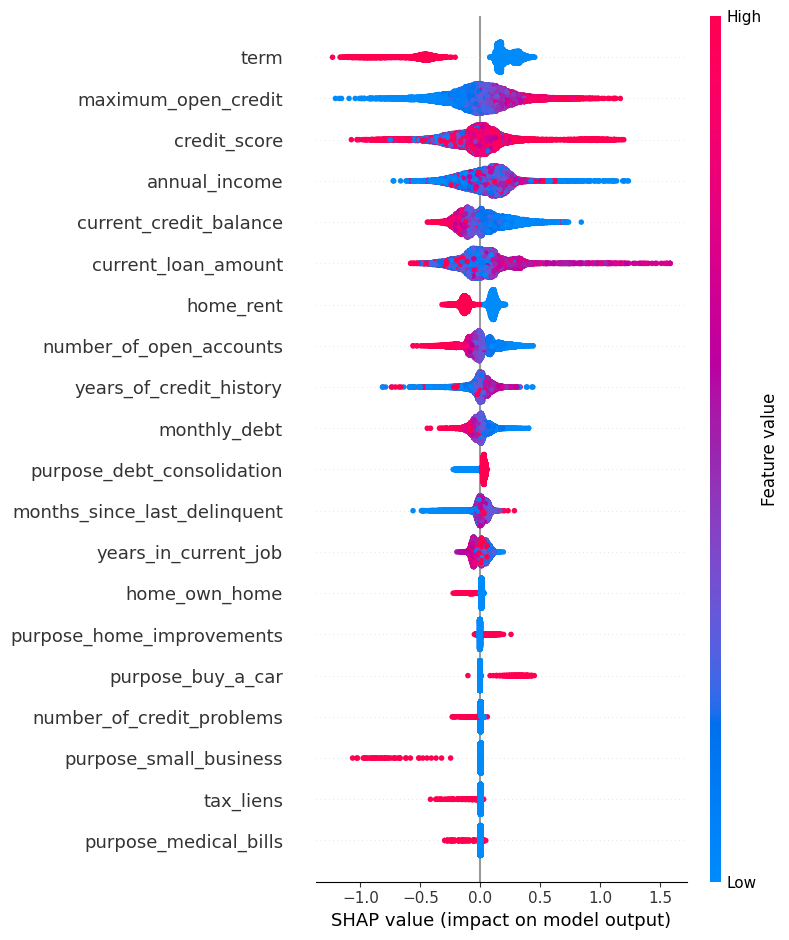

In [24]:
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test)

#shap summary plot
shap.summary_plot(shap_values, X_test)

The key takeaways from the plot above:
1. The top 3 features of this model is term, maximum_open_credit, and credit score.
2. Begining on the purpose_debt_consolidation to purpose_medical_bills, these features don't affect the prediction much, since the examples are mostly located around 0.
3. When the loans are long term, it makes the model predicts the application as not given (loan_refused). Whereas when the loans are short term, it makes the model predicts the application as given (loan_given).
4. Higher maximum open credit is also associated with the model predicts the loan application to be given.
5. Higher credit score is also associated with the model predicts the loan application to be given, although there are obvious examples that people with higher credit score also get their loans rejected as well. 

One thing to note here, the shap summary plot is quite identical with the gradient boosting one, especially for the top important features. However, it's inversed. I need to check this further. But assuming that the shap summary plot built-in the H2O library is indeed inversed, then I can say that it's very similar to the gradient boosting one.

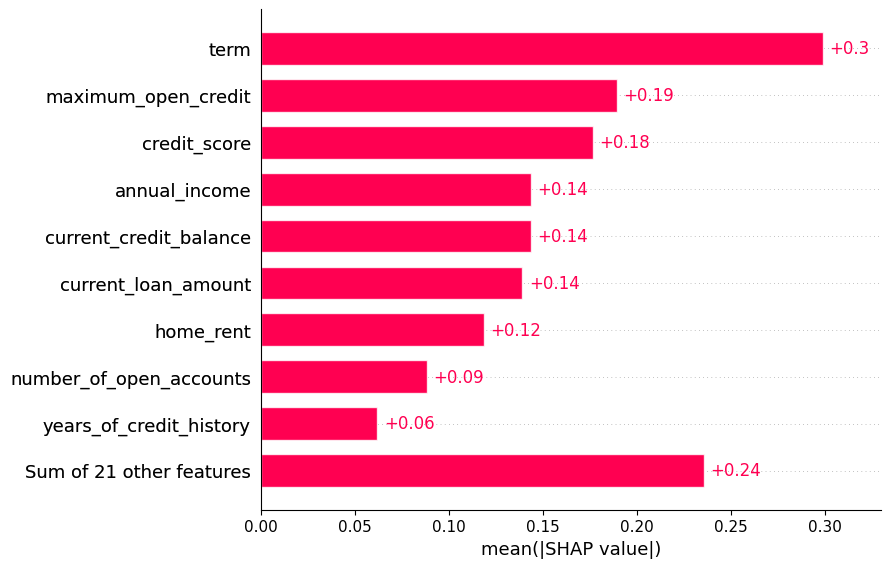

In [25]:
#bar chart for shap values
shap.plots.bar(shap_values)

The bar plot also shows the most important features and how they affect the model. Note that the feature importance scores result here is the same as the summary plot. This is because the bar chart also use SHAP instead of a more traditional method.

In [26]:
def calculate_model_metrics_xgboost(xgboost_model, X_test, y_test, model_name):
    y_pred = xgboost_model.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred)

    class_names = ['loan_refused', 'loan_given']

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Actual vs Predicted)')
    plt.show();

    # Calculate precision, recall, AUC, and F1 score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred)  
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"The F1 score for {model_name} is {f1}")
    print(f"The precision score for {model_name} is {precision}")
    print(f"The recall score for {model_name} is {recall}")
    print(f"The AUC score for {model_name} is {auc}")
    
    return f1, precision, recall, auc

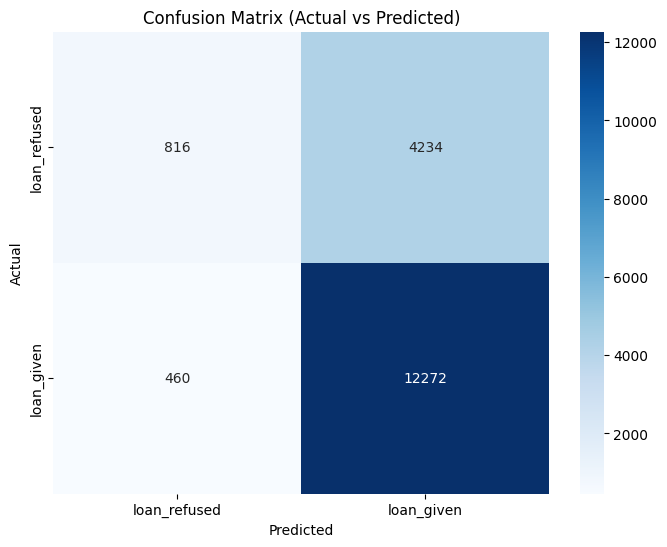

The F1 score for XGBoost is 0.6743201692727949
The precision score for XGBoost is 0.7139549166882692
The recall score for XGBoost is 0.7360251940164211
The AUC score for XGBoost is 0.5627273603891964


In [27]:
f1_xgb, precision_xgb, recall_xgb, auc_xgb = calculate_model_metrics_xgboost(best_xgb_model, X_test, y_test, "XGBoost")

Based on the confusion matrix, I think the model correctly predicts when the loan is given when it's supposed to be given. However, it does a pretty poor job in predicting when the loan is refused when it's supposed to be refused. In other words, the number of false negatives is way higher than the true negatives.

The key takeaways from the model summary are:
1. The F1 score indicates that the model can achieve a somewhat good balance between making correct positive predictions and capturing positive instances. 
2. Based on the precision score, this model is able to predict 71.39% approved loans when the loans are supposed to be approved. This is a good score for the model.
3. Based on the recall score, this model can recognize 73.6% of all eligible loan applicants. Although this number is considerably good, this means that the business has the chance of losing 27.28% eligible loan applicants.
4. The AUC score indicates that the model's power to discriminate between positive and negative cases (loan given and loan refused) not too good. It's too close to 0.5 which indicates that the model is closer to a random guess than an accurate prediction.

In the next notebook, I'm going to add features to the dataset to try to increase the performances of the models.

## Comparisons between 3 models

In [28]:
def compare_score(f1_scores, precision_scores, recall_scores, auc_scores, models):
    # Bar chart for F1 Score
    plt.figure(figsize=(12, 6))
    plt.subplot(221)
    plt.bar(models, f1_scores, color='skyblue')
    plt.title('F1 Score')
    plt.ylim(0, 1)  # Set appropriate limits

    # Bar chart for Precision
    plt.subplot(222)
    plt.bar(models, precision_scores, color='lightgreen')
    plt.title('Precision')
    plt.ylim(0, 1)  # Set appropriate limits

    # Bar chart for Recall
    plt.subplot(223)
    plt.bar(models, recall_scores, color='lightcoral')
    plt.title('Recall')
    plt.ylim(0, 1)  # Set appropriate limits

    # Bar chart for AUC Score
    plt.subplot(224)
    plt.bar(models, auc_scores, color='gold')
    plt.title('AUC Score')
    plt.ylim(0, 1)  # Set appropriate limits

    plt.tight_layout()
    plt.show();
    
    data = {
        'Model': models,
        'F1 Score': f1_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'AUC Score': auc_scores
    }

    # Create a DataFrame
    scores_df = pd.DataFrame(data)
    return scores_df

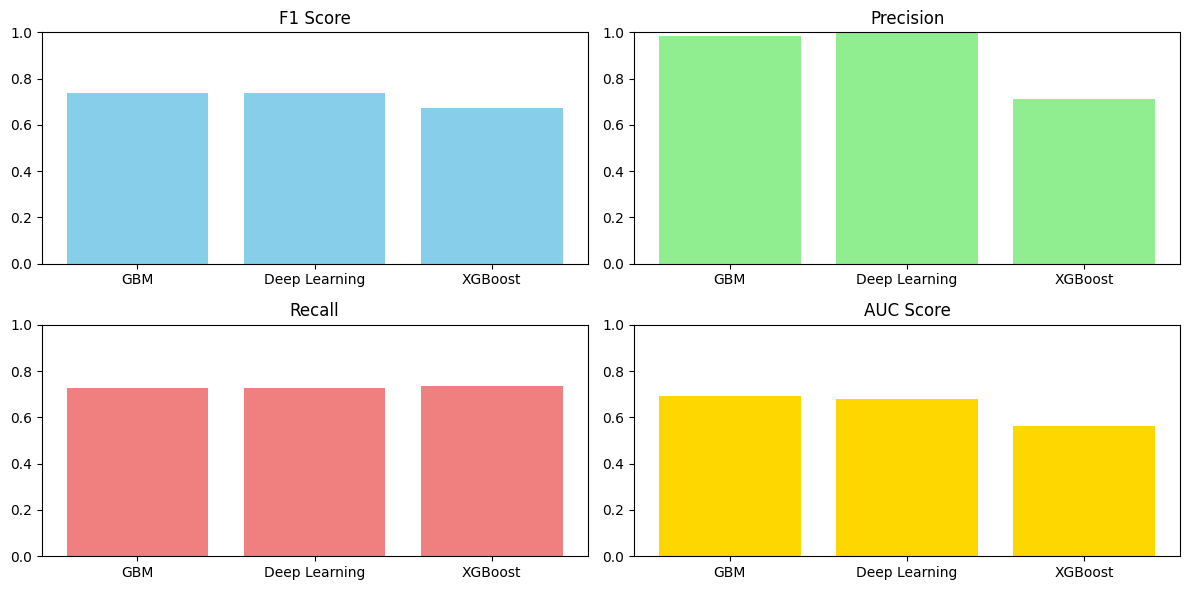

In [29]:
models = ['GBM', 'Deep Learning', 'XGBoost']
f1_scores = [f1_gbm, f1_dl, f1_xgb]
precision_scores = [precision_gbm, precision_dl, precision_xgb]
recall_scores = [recall_gbm, recall_dl, recall_xgb]
auc_scores = [auc_gbm, auc_dl, auc_xgb]
scores_df = compare_score(f1_scores, precision_scores, recall_scores, auc_scores, models)

In [30]:
scores_df

,Model,F1 Score,Precision,Recall,AUC Score
0,GBM,0.736870,0.982921,0.727268,0.691829
1,Deep Learning,0.739197,0.998454,0.728502,0.678001
2,XGBoost,0.674320,0.713955,0.736025,0.562727


Based on the comparison, the deep learning model is better than the other 2 in terms of f1 score and precision score. The one with the highest recall score is XGBoost, and the one with the highest AUC score is GBM. For now, I'm leaning towards using the deep learning model. I might be able to increase the score, but if I can't, I will use the base deep learning model.

In [31]:
#saving the model
import joblib

joblib.dump(best_xgb_model, 'model/best_xgb_model.pkl')

['model/best_xgb_model.pkl']

Now that I have all the model scores as the baseline scores, I will try to improve the scores using feature engineering and feature selection. I will continue to do this on the next notebook.

In [32]:
h2o.cluster().shutdown()

H2O session _sid_86ed closed.


In [33]:
#saving the base model scores for comparisons
scores_df.to_csv('data/base_model_scores.csv', index = False)